In [1]:
# image type, filter, airmass
# Iobs = (Ireal + S)F + D + B
# 1. Start a Jupyter notebook that will contain all sort of things you will learn in the course of your data analysis.
# Keep here your procedures that you run so that you can quickly re-run them with a few keystrokes. Also keep here anything
# you’d keep in a paper logbook regarding notes about your reduction. Markdown in your Jupyter notebook will take the place
# of formal reduction notes. The quality of the this file will make up one component of the grade for this homework.

In [2]:
# 2. Examine the images in DS9 to become familiar with where the overscan region of the chip is (on both sides of the data
# section; make note of where this is). Look at examples of bias images, dark images, and flats so that you can know by
# inspection what kind of image you are viewing.

In [3]:
# import block
import numpy as np
import astropy
from astropy.io import fits
from matplotlib import pyplot as plt
from matplotlib import rc
%matplotlib inline
from astropy.visualization import hist
from ccdproc import ImageFileCollection
import ccdproc as ccdp
from astropy.modeling import fitting
from astropy.modeling.models import Polynomial1D,Chebyshev1D,Legendre1D,Hermite1D
from astropy.nddata import CCDData

In [4]:
# import convenience plotting functions downloaded from 
# here: https://github.com/mwcraig/ccd-reduction-and-photometry-guide
phot_tutorial_dir = '/Users/marykaldor/Software/py/ccd-reduction-and-photometry-guide/notebooks/'
import sys
sys.path.insert(0,phot_tutorial_dir)
from convenience_functions import show_image

In [5]:
plt.style.use('/Users/marykaldor/Software/py/ccd-reduction-and-photometry-guide/notebooks/guide.mplstyle')
rc('font', size=20)
rc('axes', grid=True)

In [6]:
data_dir = "/Users/marykaldor/Desktop/Astro 8060/Imaging/"

In [7]:
imgs = ccdp.ImageFileCollection(data_dir)

In [8]:
testflat = data_dir + "a005.fits"
hduf = fits.open(testflat)
hdrf = hduf[0].header
hdrf['BIASSEC'] = "[1:2048, 2102:2200]"
hdrf['TRIMSEC'] = "[1:2048, 52:2100]"
imgf = hduf[0].data

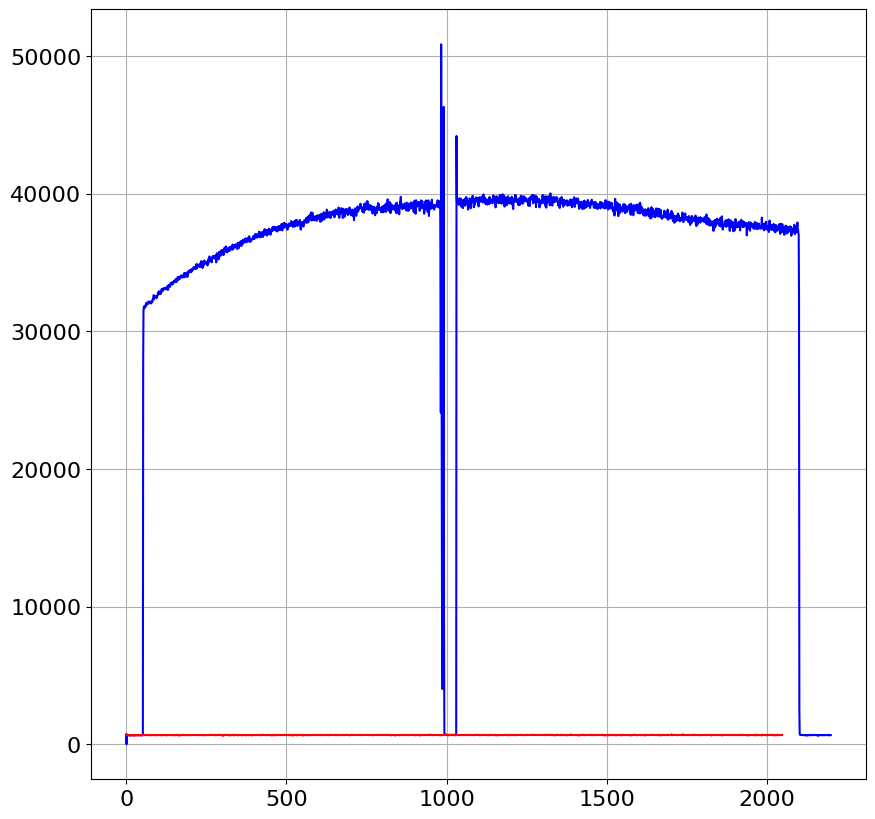

In [9]:
firstrowf = imgf[0]
firstcolf = imgf[:, 0]
plt.plot(firstrowf, color="blue")
plt.plot(firstcolf, color="red")
plt.show()
# we can see here how the first row has real data in it (values around 40,000 with values around 600 before and after it -
# these are the overscan regions
# we can also see how the first row has no real data in it (values all around 600) this is because the whole first column
# should be the overscan region

In [10]:
def startdata():
    index = 0
    for value in firstrowf:
        if value > 1000:
            return index
        index += 1

def enddata():
    index = 0
    for value in firstrowf:
        if value < 1000 and index > 2000:
            return index
        index += 1

print("start of actual data/end of left overscan is pixel", startdata())
print("end of actual data/start of right overscan is pixel", enddata())

start of actual data/end of left overscan is pixel 53
end of actual data/start of right overscan is pixel 2102


In [11]:
# 3. Assess the RMS and mean levels of an image. Use Python to practice plotting lines and columns of data from one of the
# bias images. Use Python to compute the mean and RMS of a region near the center of the chip.

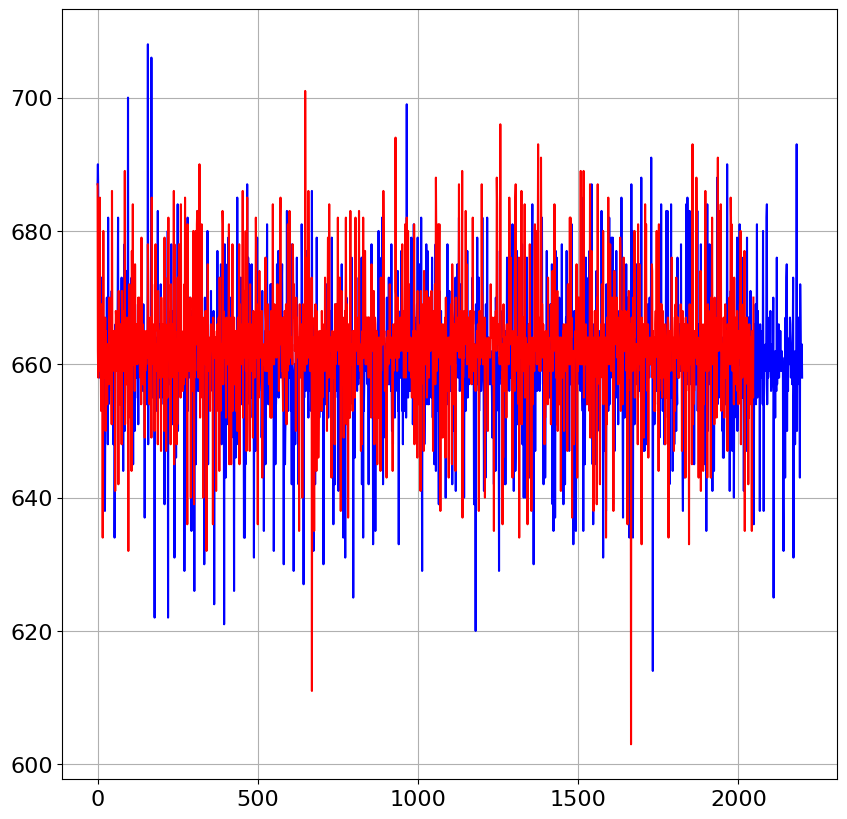

In [12]:
testbias = data_dir + "a093.fits"
hdub = fits.open(testbias)
hdrb = hdub[0].header
hdrb['BIASSEC'] = "[1:2048, 2102:2200]"
hdrb['TRIMSEC'] = "[1:2048, 52:2100]"
imgb = hdub[0].data
firstrowb = imgb[0]
firstcolb = imgb[:, 0]
plt.plot(firstrowb, color="blue")
plt.plot(firstcolb, color="red")
plt.show()

[[27873 31545 31731 ... 37014 32222  2606]
 [29924 34239 34528 ... 35911 33643  2636]
 [31198 33912 34039 ... 35635 34271  2682]
 ...
 [33407 35486 36170 ... 37298 36878  2824]
 [32965 35647 35707 ... 37304 36685  2840]
 [33253 35780 35593 ... 37297 36692  2826]]
type <class 'numpy.ndarray'>


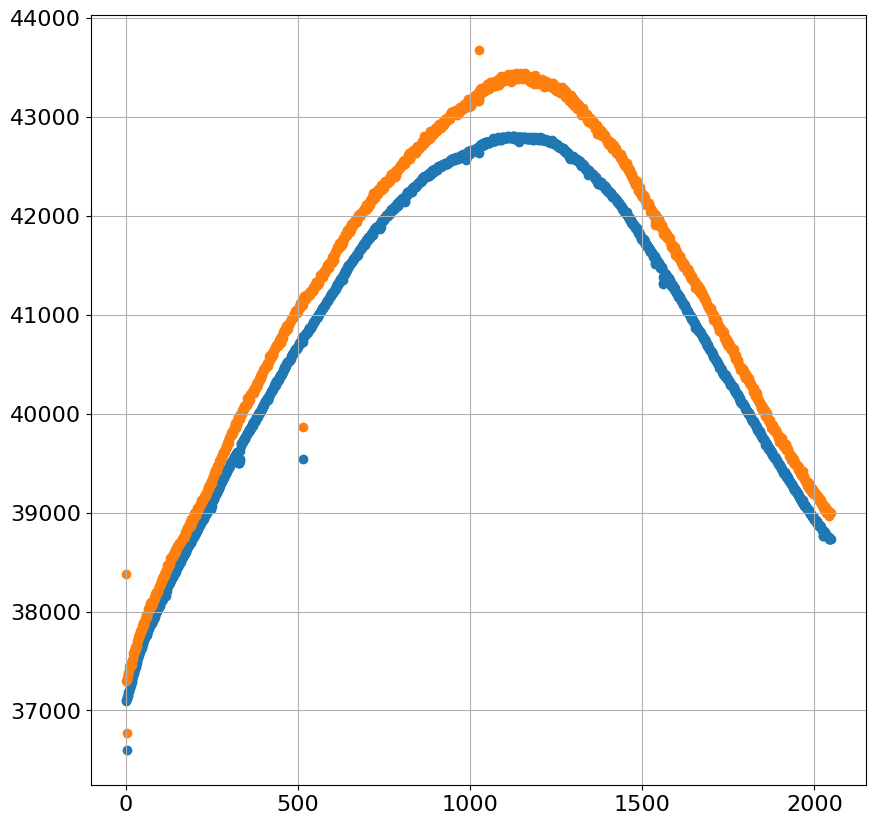

In [13]:
biassec_range = hduf[0].header["BIASSEC"]
# print(biassec_range)
# biassec_data = img[:, 2103:2200]
biassec_data = imgf[:, 53:2102]
# print(np.shape(biassec_data))
print(biassec_data)

row = np.arange(2048)
mean = np.mean(biassec_data, axis=1)
median = np.median(biassec_data, axis=1)
plt.scatter(row, mean)
plt.scatter(row, median)
# let's use a mean because the median is weird!
print("type", type(biassec_data))
'''
for i in biassec_data:
    plt.plot(row, np.median(i))
    row += 1
'''
             
# plt.plot(biassec_data)
plt.show()

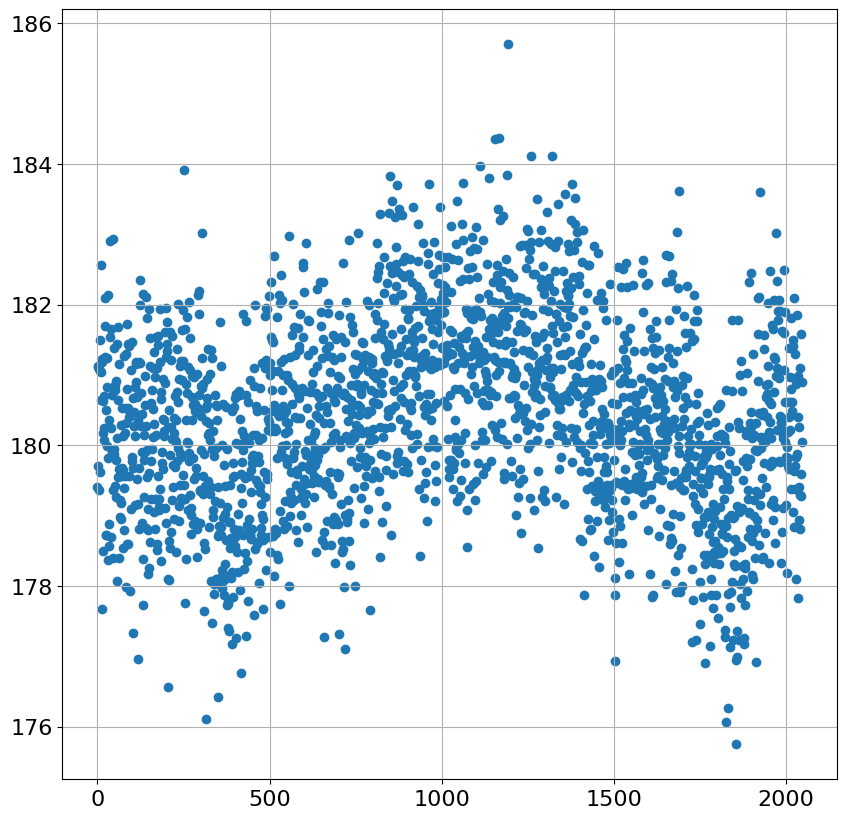

In [14]:
meansq = np.mean(biassec_data**2, axis=1)
rms = np.sqrt(meansq)
plt.scatter(row, rms)
plt.show()

In [15]:
# Looking at the difference in the center of the chip
midpointm = int(len(mean)/2)
midmean = mean[midpointm]
print("midmean", midmean)
midpointr = int(len(rms)/2)
midrms = mean[midpointr]
print("midrms", midrms)
print("difference", midmean-midrms)

midmean 42702.853099072716
midrms 42702.853099072716
difference 0.0


In [16]:
# 4. Open Phillip Massey’s users’s guide to ccd reductions with IRAF, linked on the class website. Use this as a rough guide,
# but we won’t follow everything he recommends (there are just too many ways to do the same thing!). An example of these steps
# in action can be found at the CCD reduction and photometry guide Github tutorial also linked from the class website.

In [17]:
# 5. Examine the all bias exposures (or overscan regions throughout the night) and quantify how much the bias level changes
# throughout the night. Compare the mean level of the biases to the mean levels of the overscan regions from other files
# throughout the night. How much variation do you find? Make an argument for whether it would be a good or bad idea to combine
# all of the biases to make a master bias and subtract that from all the images versus using the overscan region of each image
# as an estimate of the bias level.

range throughout bias frames 0.32912997159087354


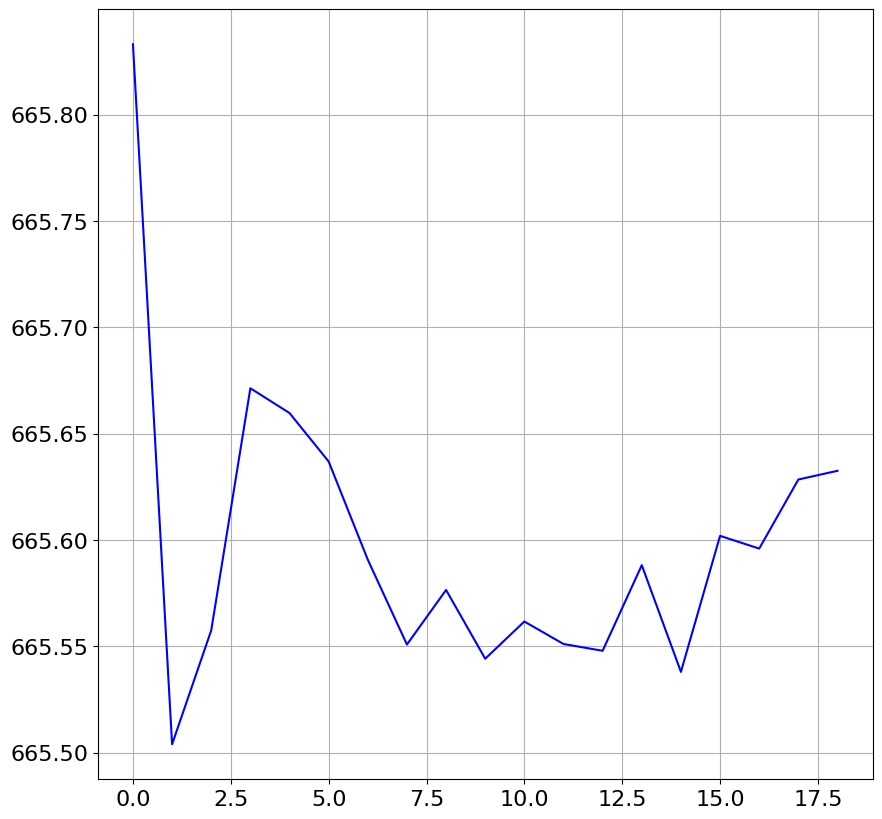

In [18]:
biasfiles = [data_dir+"a"+str(num).zfill(3)+".fits" for num in np.arange(93,112)] # forms a list of strings
biashdu = [fits.open(file) for file in biasfiles] # forms a list of header objects
biasdata = [item[0].data for item in biashdu] # forms a list of arrays. in these arrays are arrays, and within those arrays are uint16 (basically pixel values
# within rows within images, so 3 layers of data storage)
biasmean = [np.mean(frame) for frame in biasdata] # forms a list of floats
biasmedian = [np.median(frame) for frame in biasdata] # forms a list of floats
plt.plot(np.arange(len(biasmean)), biasmean, color="blue")
print("range throughout bias frames", np.max(biasmean)-np.min(biasmean))
# This does not seem to be a large range. The first bias readout was the highest, and the second readout was the lowest. After that, the values seemed to level
# out to a certain extent.
plt.show()

(58, 2048, 98)
range throughout flat overscan regions 2818.448466398278


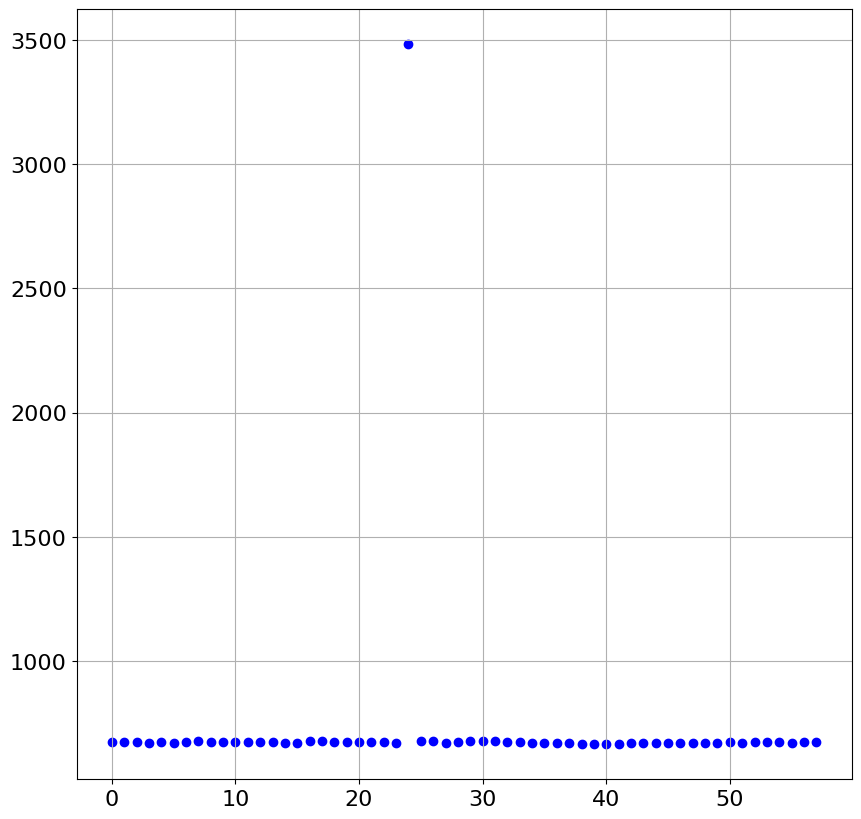

In [19]:
flatfiles = [data_dir+"a"+str(num).zfill(3)+".fits" for num in np.arange(5,63)] # forms a list of strings
flathdu = [fits.open(file) for file in flatfiles] # forms a list of header objects
flatdata = [item[0].data for item in flathdu] # forms a list of arrays. in these arrays are arrays, and within those arrays are uint16 (basically pixel values
# within rows within images, so 3 layers of data storage)
flatoverscan = [img[:, 2102:] for img in flatdata]
print(np.shape(flatoverscan))
flatomean = [np.mean(frame) for frame in flatoverscan] # forms a list of floats
flatomedian = [np.median(frame) for frame in flatoverscan] # forms a list of floats
plt.scatter(np.arange(len(flatomean)), flatomean, color="blue")
print("range throughout flat overscan regions", np.max(flatomean)-np.min(flatomean))
# This is a much larger range. However, there is one clear outlier in the flat overscan regions. a029.fits has a weird bottom of the right overscan region.
# We can also see in the log file that it was listed as saturated, which is probably why the mean is huge!
plt.show()

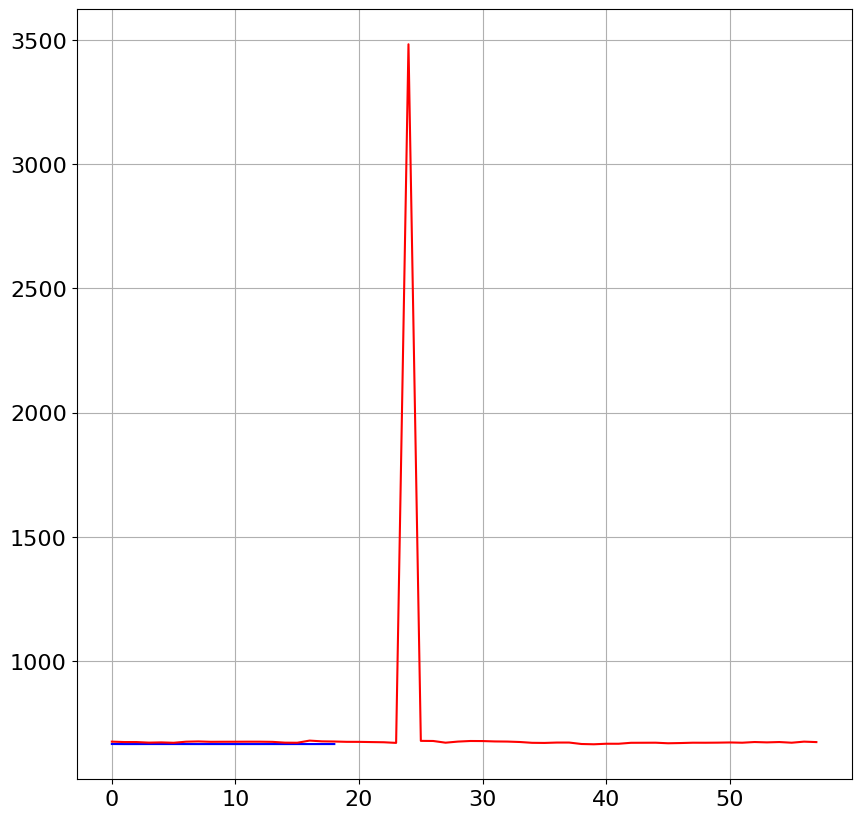

8.727630109717133


In [20]:
plt.plot(np.arange(len(biasmean)), biasmean, color="blue")
plt.plot(np.arange(len(flatomean)), flatomean, color="red")
plt.show()
# These values are similar, but the flat overscan means are slightly greater than the bias means.
i = 0
difflist = []
while i < len(biasmean):
    bmean = biasmean[i]
    fmean = flatomean[i]
    diff = fmean-bmean
    difflist.append(diff)
    i += 1

meandiff = np.mean(difflist)
print(meandiff)
# The mean difference between flat overscan mean and bias mean is around 9 ADUs. This is not very large, so it may be alright to create a master bias from the
# bias frames and apply them to all the images, rather than using the overscan region for every image. To add, the overscan region has demonstrated it has
# outliers, but the bias mean seems to eliminate any odd behavior and shows more consistency. Using the overscan region may result in weird image reduction
# if one isn't aware of what an odd/outlier value may be for a mean overscan region value.

In [21]:
# 6. Using CCDPROC.SUBTRACT_OVERSCAN and CCDPROC.TRIM_IMAGE, fit and subtract the overscan region of each image and trim the
# image to remove the overscan region. In the overscan fitting, try out ’chebyshev’, ’legendre’, and ’hermite’, and ’polynomial’
# of various orders for the fitting function. Qualitatively try to summarize the differences between the functions (you can
# also look up and summarize the properties of these types of polynomials, but this is not required). Also try orders 1
# through about 8, and make an argument for how large an order is necessary to fit the overscan region.

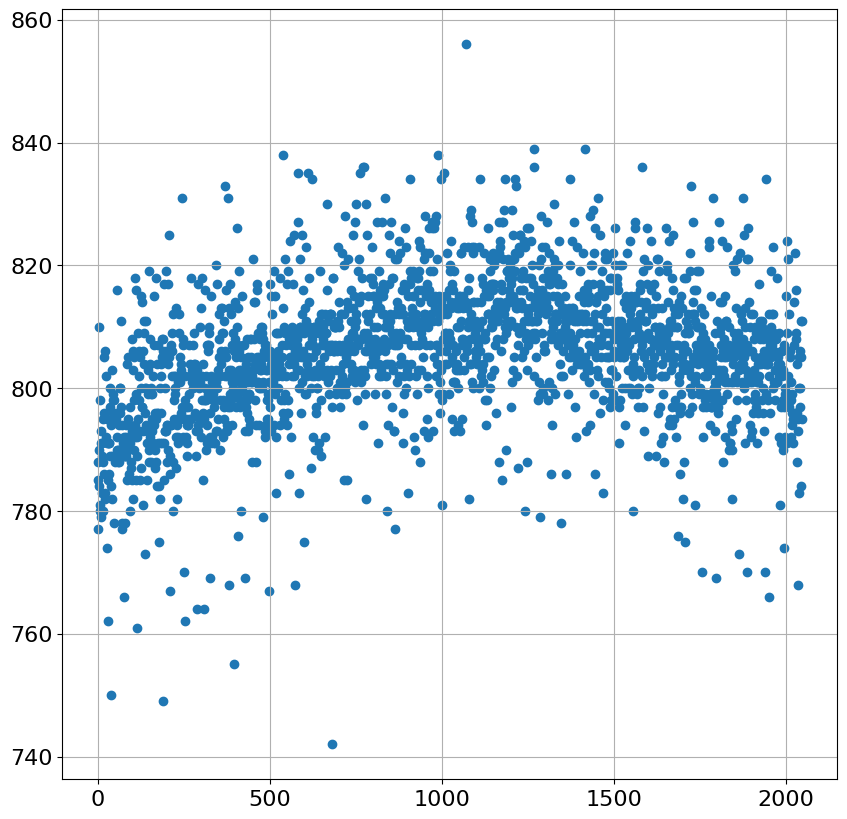

In [22]:
meanrowflato = [np.mean(row[0]) for row in flatoverscan[0]]
plt.scatter(np.arange(2048), meanrowflato)
plt.show()

Model: Chebyshev1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 3
Domain: (0.0, 2047.0)
Parameters:
            c0                c1                c2                  c3        
    ----------------- ----------------- ------------------ -------------------
    802.8853761445398 4.952451616089712 -8.058837923465623 0.08569235957171337


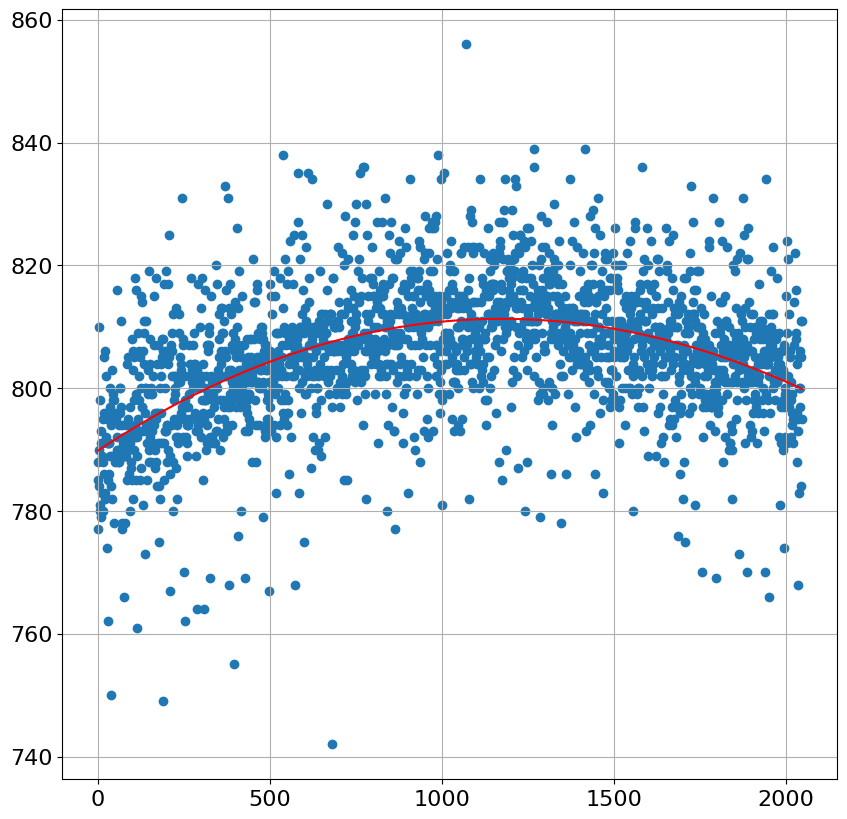

In [23]:
model = Chebyshev1D(3) # use prime number counting
fitter = fitting.LinearLSQFitter()
best_fit = fitter(model, np.arange(2048), meanrowflato)
print(best_fit)
plt.scatter(np.arange(2048), meanrowflato)
plt.plot(np.arange(2048), best_fit(np.arange(2048)), color="red")
plt.show()

Model: Legendre1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 4
Domain: (0.0, 2047.0)
Parameters:
            c0               c1                 c2                 c3                 c4        
    ----------------- ---------------- ------------------- ------------------ ------------------
    805.5713066987081 4.90103620034668 -10.746861850027809 0.1371077753147369 0.7148289256272197


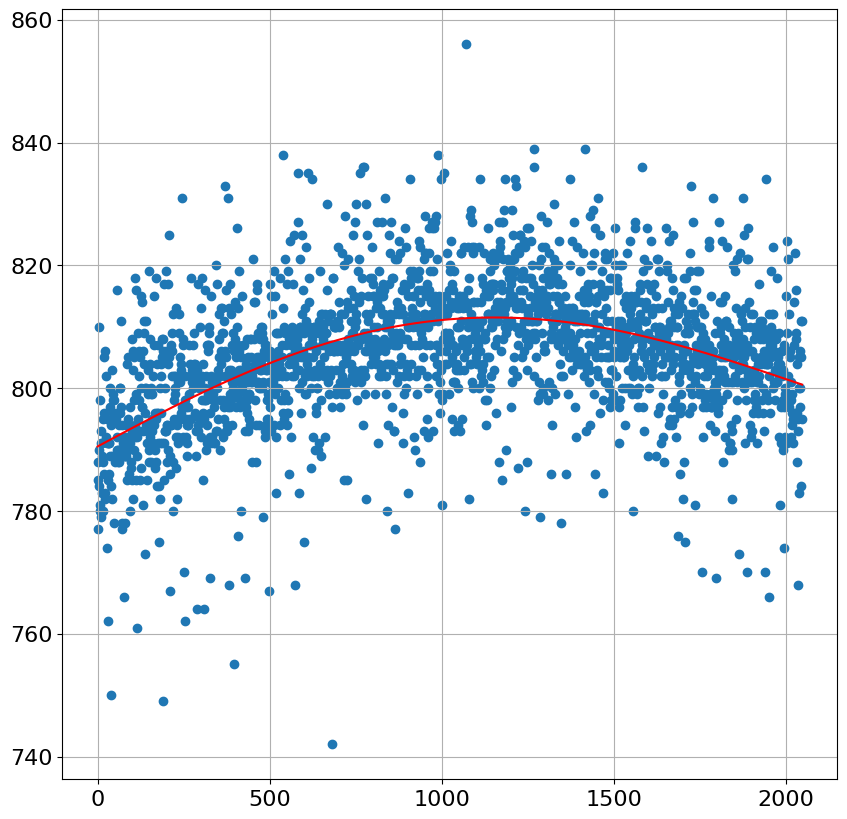

In [24]:
model = Legendre1D(4) # use orthogonal polynomials
fitter = fitting.LinearLSQFitter()
best_fit = fitter(model, np.arange(2048), meanrowflato)
print(best_fit)
plt.scatter(np.arange(2048), meanrowflato)
plt.plot(np.arange(2048), best_fit(np.arange(2048)), color="red")
plt.show()

Model: Hermite1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Domain: (0.0, 2047.0)
Parameters:
            c0                c1                 c2        
    ----------------- ------------------ ------------------
    802.8853761445392 2.4506185372437415 -4.029418961732876


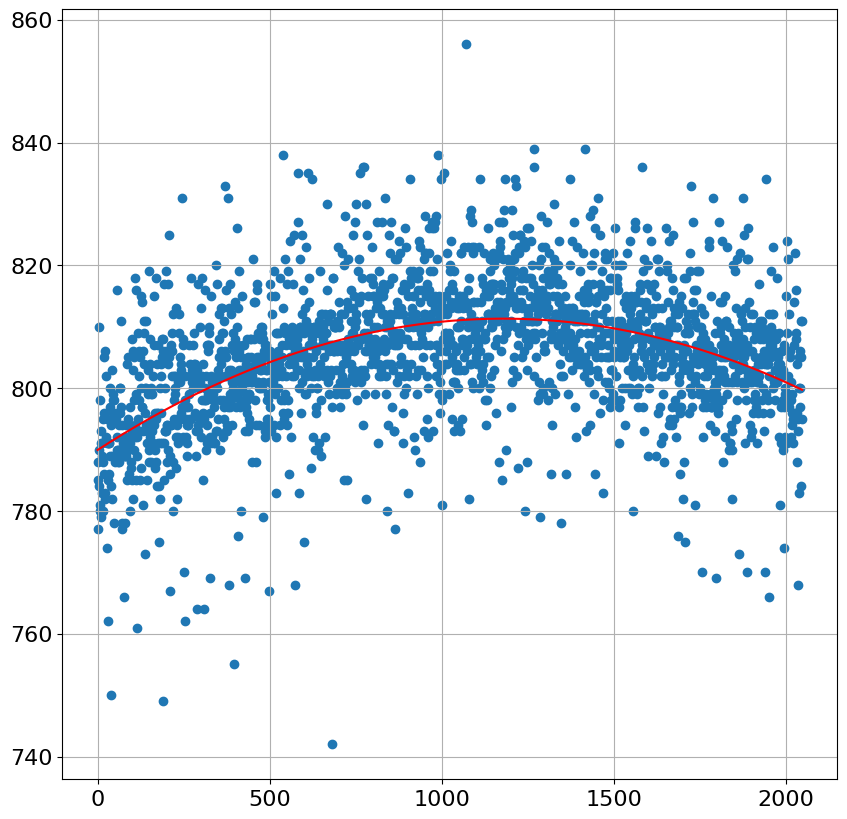

In [25]:
model = Hermite1D(2) # another use of orthogonal polynomials
fitter = fitting.LinearLSQFitter()
best_fit = fitter(model, np.arange(2048), meanrowflato)
print(best_fit)
plt.scatter(np.arange(2048), meanrowflato)
plt.plot(np.arange(2048), best_fit(np.arange(2048)), color="red")
plt.show()
# This is the lowest order that still provides a good fit, let's run with this!

 [astropy.modeling.fitting]



Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 8
Parameters:
            c0                 c1                    c2                     c3           ...           c6                    c7                     c8          
    ----------------- ------------------- ----------------------- ---------------------- ... --------------------- ---------------------- ----------------------
    789.7883941510491 0.03708747922751751 -1.6367665104197907e-05 3.1969678152442223e-10 ... 5.808795052989874e-39 1.0032840570589912e-48 1.6013052065703565e-58


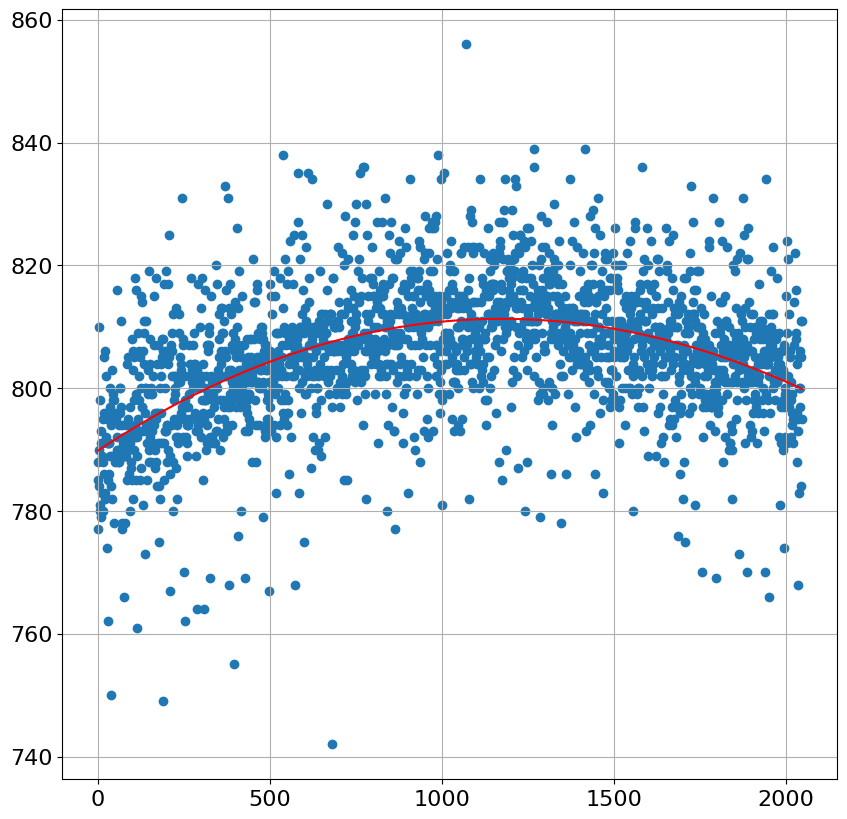

In [26]:
model = Polynomial1D(8) # sum of variables to exponents
fitter = fitting.LinearLSQFitter()
best_fit = fitter(model, np.arange(2048), meanrowflato)
print(best_fit)
plt.scatter(np.arange(2048), meanrowflato)
plt.plot(np.arange(2048), best_fit(np.arange(2048)), color="red")
plt.show()

In [27]:
from astropy.modeling import models as mod
sciencefiles1 = [data_dir+"a"+str(num).zfill(3)+".fits" for num in np.arange(64,93)] # forms a list of strings
sciencefiles2 = [data_dir+"a"+str(num).zfill(3)+".fits" for num in np.arange(112,140)] # forms a list of strings
sciencefiles3 = [data_dir+"a"+str(num).zfill(3)+".fits" for num in np.arange(142,152)] # forms a list of strings
sciencefiles4 = [data_dir+"a"+str(num).zfill(3)+".fits" for num in np.arange(153,164)] # forms a list of strings
sciencefiles5 = [data_dir+"a"+str(num).zfill(3)+".fits" for num in np.arange(165,182)] # forms a list of strings
sciencefiles6 = [data_dir+"a"+str(num).zfill(3)+".fits" for num in np.arange(183,193)] # forms a list of strings
sciencefiles7 = [data_dir+"a"+str(num).zfill(3)+".fits" for num in np.arange(194,221)] # forms a list of strings
sciencefiles8 = [data_dir+"a"+str(num).zfill(3)+".fits" for num in np.arange(237,247)] # forms a list of strings
sciencefiles = sciencefiles1 + sciencefiles2 + sciencefiles3 + sciencefiles4 + sciencefiles5 + sciencefiles6 + sciencefiles7 + sciencefiles8
# this is all of them, skipping the bias frames in the middle
sciencehdu = [fits.open(file) for file in sciencefiles] # forms a list of header objects
sciencedata = [item[0].data for item in sciencehdu] # forms a list of arrays. in these arrays are arrays, and within those arrays are uint16 (basically pixel values
# within rows within images, so 3 layers of data storage)
scienceccd = [CCDData(img, unit="adu") for img in sciencedata]
sciencesub = [ccdp.subtract_overscan(img, overscan=img[:, 2102:], model=mod.Hermite1D(2)) for img in scienceccd]
sciencesubtrim = [ccdp.trim_image(img[:, 53:2101]) for img in sciencesub]

In [28]:
'''
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
show_image(imgf.data, cmap='gray', ax=ax1, fig=fig)
ax1.set_title('Raw flat')
show_image(cheb1trimsubflat.data, cmap='gray', ax=ax2, fig=fig)
show_image(leg1trimsubflat.data, cmap='gray', ax=ax3, fig=fig)
ax2.set_title('Flat, cheb1 o&t')
ax3.set_title('Flat, leg1 o&t')
'''

"\nfig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))\nshow_image(imgf.data, cmap='gray', ax=ax1, fig=fig)\nax1.set_title('Raw flat')\nshow_image(cheb1trimsubflat.data, cmap='gray', ax=ax2, fig=fig)\nshow_image(leg1trimsubflat.data, cmap='gray', ax=ax3, fig=fig)\nax2.set_title('Flat, cheb1 o&t')\nax3.set_title('Flat, leg1 o&t')\n"

In [29]:
# 7. Combine the bias frames into a master bias frame using CCDPROC.COMBINE. By visual inspection or using image statistics,
# decide whether it is appropriate to combine all your bias exposures to make 1 master bias, or whether you need to restrict
# the input frames because of variations among your bias frames. Are there trends in your sequence of bias frames? Does either
# the level, or the pattern of the bias change throughout the night? If so, by how much? How much noise would you be adding to
# your data if you decide to do a bias subtraction in addition to your overscan subtraction. Do the subtraction of your master
# bias from all other science frames if you can justify that it is warranted.

In [30]:
biasccd = [CCDData(img, unit="adu") for img in biasdata]
biassub = [ccdp.subtract_overscan(img, overscan=img[:, 2102:], model=mod.Hermite1D(2)) for img in biasccd]
biassubtrim = [ccdp.trim_image(img[:, 53:2101]) for img in biassub]
masterbias = ccdp.combine(biassubtrim)
print(type(masterbias))
masterbiassub = ccdp.subtract_bias(biassubtrim[0], masterbias)

<class 'astropy.nddata.ccddata.CCDData'>


In [31]:
# As noted earlier, the bias averages appear to be rather consistent and free of outliers. This makes the creation of a master bias seem reasonable! There 
# are no trends in the sequence of the bias frames; the level and pattern of the bias do not change throughout the night.
rmsoverscan = np.sqrt(np.mean(np.asarray(biassubtrim[0])**2))
rmsbias = np.sqrt(np.mean(np.asarray(masterbiassub)**2))
print("overscan rms", rmsoverscan)
print("bias subtracted rms", rmsbias)
print("difference", rmsoverscan-rmsbias)
# I actually lower the RMS as I subtract the bias from an image, so this shows that master bias subtraction is a good thing and that I should do it on all
# science frames!

overscan rms 10.170323340159017
bias subtracted rms 8.958017907021885
difference 1.2123054331371321


In [32]:
sciencesubtrimbias = [ccdp.subtract_bias(img, masterbias) for img in sciencesubtrim]

In [33]:
# 8. Now examine the ‘dark’ images quantitatively and estimate the range of dark current (electrons per pixel per second) you
# see in the darks. WIRO Prime’s gain is 2.5 e−/ADU. Use Python to inspect the header and see the exposure time in each of the
# darks. Pixel values will vary! Be careful to avoid being fooled by cosmic rays, which will appear as large bright spots
# usually spread over a few pixels, whereas high dark current is usually isolated to just individual pixels.

range throughout dark frames 0.0762956385712652 ADUs =  0.190739096428163 electrons/pix


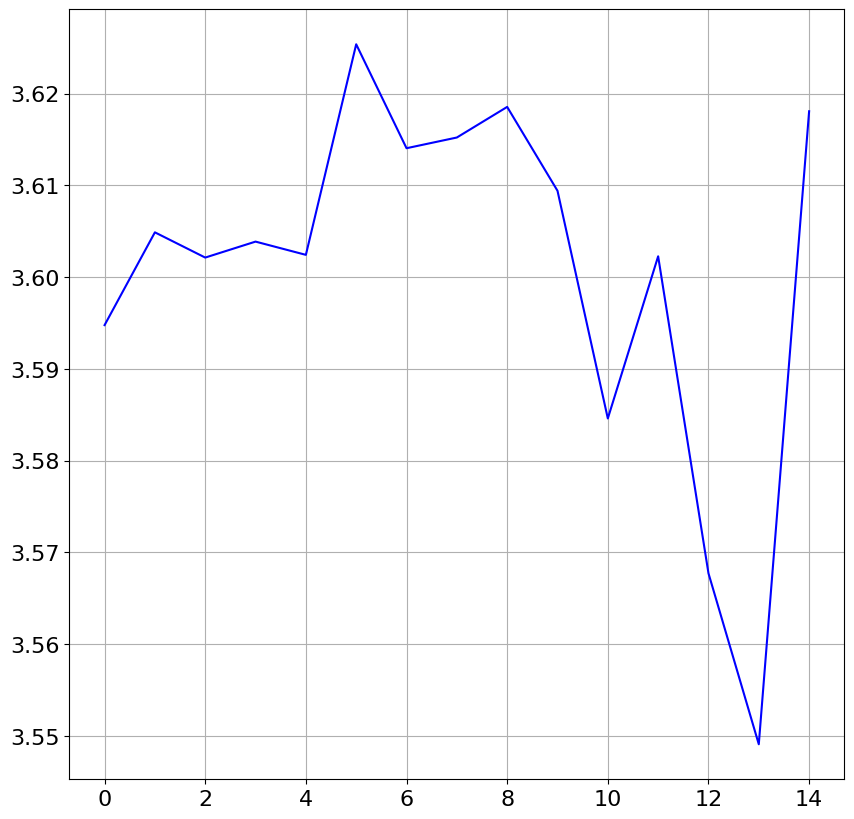

In [35]:
darkfiles = [data_dir+"d"+str(num).zfill(3)+".fits" for num in np.arange(1,16)] # forms a list of strings
darkhdu = [fits.open(file) for file in darkfiles] # forms a list of header objects
darkdata = [item[0].data for item in darkhdu] # forms a list of arrays. in these arrays are arrays, and within those arrays are uint16 (basically pixel values
# within rows within images, so 3 layers of data storage)
darkccd = [CCDData(img, unit="adu") for img in darkdata]
darksub = [ccdp.subtract_overscan(img, overscan=img[:, 2102:], model=mod.Hermite1D(2)) for img in darkccd]
darksubtrim = [ccdp.trim_image(img[:, 53:2101]) for img in darksub]
darksubtrimbias = [ccdp.subtract_bias(img, masterbias) for img in darksubtrim]
darkmean = [np.mean(np.asarray(frame)) for frame in darksubtrim] # forms a list of floats
# darkmedian = [np.median(frame) for frame in darkdata] # forms a list of floats
plt.plot(np.arange(len(darkmean)), darkmean, color="blue")
print("range throughout dark frames", np.max(darkmean)-np.min(darkmean), "ADUs = ", (np.max(darkmean)-np.min(darkmean))*2.5, "electrons/pix")
# This does not seem to be a large range.
plt.show()

In [36]:
darktime = [hdu[0].header["EXPTIME"] for hdu in darkhdu]
print(darktime)
darktime = np.asarray(darktime)
darkrate = np.asarray(darkmean)*2.5/darktime
print(darkrate, "electron/pix*sec")

[2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 300, 300, 300, 300, 300]
[4.49345932 4.50610141 4.5026624  4.50483762 4.50303309 1.81268893
 1.80702444 1.80760787 1.8092758  1.80470471 0.02987162 0.0300189
 0.02973099 0.02957569 0.03015064] electron/pix*sec


In [37]:
# 9. Use CCDPROC.COMBINE to combine darks together to make a master dark. You will need to play with different combination
# parameters to see which one does the best job of eliminating cosmic rays. At a minimum, do
# • A straight average of all dark frames.
# • A straight median of all dark frames.
# • An average where outlier pixels are rejected if they are more than 3σ away from the mean.
# • A median where outlier pixels are rejected if they are more than 3σ away from the mean.
# Use the resulting RMS in the master image as an indicator of which combination procedure is best. Compare your master dark
# to your master bias to estimate the significance of the highest dark count pixels. How many times larger is the typical dark
# current than the noise (σ) in the master image?

In [44]:
masterdarkav = ccdp.combine(darksubtrimbias, method="average")
masterdarkmed = ccdp.combine(darksubtrimbias, method="median")
masterdarkav3sig = ccdp.combine(darksubtrimbias, method="average", sigma_clip=True, sigma_clip_low_thresh=3, sigma_clip_high_thresh=3)
masterdarkmed3sig = ccdp.combine(darksubtrimbias, method="median", sigma_clip=True, sigma_clip_low_thresh=3, sigma_clip_high_thresh=3)
rmsmda = np.sqrt(np.mean(np.asarray(masterdarkav)**2))
rmsmdm = np.sqrt(np.mean(np.asarray(masterdarkmed)**2))
rmsmda3s = np.sqrt(np.mean(np.asarray(masterdarkav3sig)**2))
rmsmdm3s = np.sqrt(np.mean(np.asarray(masterdarkmed3sig)**2))
print(rmsmda)
print(rmsmdm)
print(rmsmda3s)
print(rmsmdm3s)
masterdarkmean = np.mean(np.asarray(masterdarkav3sig))
masterbiasmean = np.mean(np.asarray(masterbias))
diff = masterbiasmean-masterdarkmean
print("difference between master dark mean and master bias mean", diff)
s = masterdarkmean - rmsmda3s
print("the typical dark current is ", s, "larger than the noise in the master dark")
# This means it's basically neglible!

2.5710552264100146
2.327250164862849
2.2493339351182784
2.327789204259673
difference between master dark mean and master bias mean 3.362587460766923
the typical dark current is  -2.13602796269652 larger than the noise in the master dark
